In [46]:
class Agent(object):
    
    def __init__(self, env):
        """set up the agent"""
        self.env = env

    def go(self, n):
        """acts for n time steps"""
        raise NotImplementedError("go")   # abstract method


In [47]:
from lib.display import Displayable


class Environment(Displayable):
    
    def initial_percepts(self):
        """returns the initial percepts for the agent"""
        raise NotImplementedError("initial_percepts")   # abstract method

    def do(self, action):
        """does the action in the environment returns the next percept"""
        raise NotImplementedError("do")   # abstract method


In [48]:
def pick_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the
        probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it, prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError("{} is not a probability distribution".format(item_prob_dist))


In [49]:
import random


class TP_env(Environment):
    
    prices = [
        234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211, 234, 234,
        234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255, 255, 260,
        260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260, 265, 265,
        150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265, 265, 265,
        265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265, 260, 265,
        270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265, 270, 270
    ]
    
    # Maximum of random value added to get price
    max_price_addon = 20

    def __init__(self):
        """paper buying agent"""
        self.time = 0
        self.stock = 20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percepts(self):
        """return initial percepts"""
        self.stock_history.append(self.stock)
        price = self.prices[0] + random.randrange(self.max_price_addon)
        self.price_history.append(price)
        return {
            'price': price,
            'instock': self.stock
        }

    def do(self, action):
        """does action (buy) and returns percepts (price and instock)"""

        used = pick_from_dist({
            6:0.1,
            5:0.1,
            4:0.2,
            3:0.3,
            2:0.2,
            1:0.1
        })
        bought = action['buy']
        self.stock = self.stock + bought - used
        self.stock_history.append(self.stock)
        self.time += 1
        price = (
            self.prices[self.time % len(self.prices)] # repeating pattern
            + random.randrange(self.max_price_addon)  # plus randomness
            + self.time                               # plus inflation
        )
        self.price_history.append(price)
        return {
            'price': price,
            'instock': self.stock
        }


In [51]:
class TP_agent(Agent):
    
    def __init__(self, env):
        self.env = env
        self.spent = 0
        percepts = env.initial_percepts()
        self.avg = self.last_price = percepts['price']
        self.instock = percepts['instock']

    def go(self, n):
        """go for n time steps"""
        for i in range(n):
            if self.last_price < 0.9 * self.avg and self.instock < 60:
                tobuy = 48
            elif self.instock < 12:
                tobuy = 12
            else:
                tobuy = 0
            self.spent += tobuy * self.last_price
            percepts = env.do({
                'buy': tobuy
            })
            self.last_price = percepts['price']
            self.avg += (self.last_price - self.avg) * 0.05
            self.instock = percepts['instock']


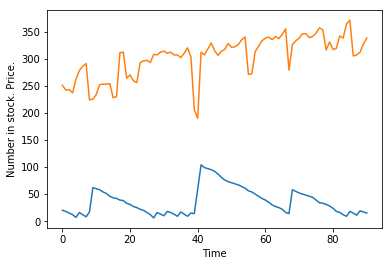

In [52]:
env = TP_env()
ag = TP_agent(env)
#ag.go(90)
#ag.spent/env.time   ## average spent per time period

import matplotlib.pyplot as plt


class Plot_prices(object):
    """Set up the plot for history of price and number in stock"""
    
    def __init__(self, ag,env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Number in stock. Price.")

    def plot_run(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.stock_history, label="In stock")
        plt.plot(range(num),env.price_history, label="Price")
        #plt.legend(loc="upper left")
        plt.draw()

        
pl = Plot_prices(ag, env)
ag.go(90)
pl.plot_run()


In [55]:
import math


class Rob_env(Environment):
    
    def __init__(self, walls={}):
        """walls is a set of line segments where
           each line segment is of the form ((x0,y0),(x1,y1))
        """
        self.walls = walls


In [56]:
import time
import math
import matplotlib.pyplot as plt


class Rob_body(Environment):
    
    def __init__(self, env, init_pos=(0,0,90)):
        """env is the current environment
           init_pos is a triple of (x-position, y-position, direction) 
           direction is in degrees; 0 is to right, 90 is straight-up, etc
        """
        self.env = env
        self.rob_x, self.rob_y, self.rob_dir = init_pos
        
        # Degrees that a left makes
        self.turning_angle = 18
        
        # Length of the whisker
        self.whisker_length = 6
        
        # Angle of whisker relative to robot
        self.whisker_angle = 30
        self.crashed = False
        
        # The following control how it is plotted
        self.plotting = True      # whether the trace is being plotted
        self.sleep_time = 0.05    # time between actions (for real-time plotting)
        
        # The following are data structures maintained:
        self.history = [(self.rob_x, self.rob_y)] # history of (x,y) positions
        self.wall_history = []                    # history of hitting the wall

    def percepts(self):
        return {
            'rob_x_pos': self.rob_x,
            'rob_y_pos': self.rob_y,
            'rob_dir': self.rob_dir,
            'whisker': self.whisker(),
            'crashed':self.crashed
        }

    # Use percept function for initial percepts too
    initial_percepts = percepts

    def do(self,action):
        """action is {'steer':direction}
           direction is 'left', 'right' or 'straight'
        """
        if self.crashed:
            return self.percepts()
        direction = action['steer']  
        compass_deriv = {
            'left': 1,
            'straight': 0,
            'right': -1
        }[direction] * self.turning_angle
        
        # make in range [0,360)
        self.rob_dir = (self.rob_dir + compass_deriv + 360) % 360
        rob_x_new = self.rob_x + math.cos(self.rob_dir * math.pi / 180)
        rob_y_new = self.rob_y + math.sin(self.rob_dir * math.pi / 180)
        path = (
            (self.rob_x, self.rob_y),
            (rob_x_new, rob_y_new)
        )
        if any(line_segments_intersect(path, wall) for wall in self.env.walls):
            self.crashed = True
            if self.plotting:
                plt.plot([self.rob_x], [self.rob_y], "r*", markersize=20.0)
                plt.draw()
        self.rob_x, self.rob_y = rob_x_new, rob_y_new 
        self.history.append((self.rob_x, self.rob_y))
        if self.plotting and not self.crashed:
            plt.plot([self.rob_x], [self.rob_y], "go")
            plt.draw()
            plt.pause(self.sleep_time)
        return self.percepts()

    def whisker(self):
        """returns true whenever the whisker sensor intersects with a wall"""
        whisk_ang_world = (self.rob_dir-self.whisker_angle) * math.pi / 180
        # angle in radians in world coordinates
        wx = self.rob_x + self.whisker_length * math.cos(whisk_ang_world)
        wy = self.rob_y + self.whisker_length * math.sin(whisk_ang_world)
        whisker_line = (
            (self.rob_x, self.rob_y),
            (wx, wy)
        )
        hit = any(line_segments_intersect(whisker_line, wall) for wall in self.env.walls)
        if hit:
            self.wall_history.append((self.rob_x, self.rob_y))
            if self.plotting:
                plt.plot([self.rob_x], [self.rob_y], "ro")
                plt.draw()
        return hit


def line_segments_intersect(linea, lineb):
    """returns true if the line segments, linea and lineb intersect.
       A line segment is represented as a pair of points.
       A point is represented as a (x,y) pair.
    """
    ((x0a, y0a), (x1a, y1a)) = linea
    ((x0b, y0b), (x1b, y1b)) = lineb
    da, db = x1a - x0a, x1b - x0b
    ea, eb = y1a - y0a, y1b - y0b
    denom = db * ea - eb * da
    if denom == 0:                                      # line segments are parallel
        return False
    cb = (da * (y0b - y0a) - ea * (x0b - x0a)) / denom  # position along line b
    if cb < 0 or cb > 1:
        return False
    ca = (db * (y0b - y0a) - eb * (x0b - x0a)) / denom  # position along line a
    return 0 <= ca <= 1

# Test cases:
# assert line_segments_intersect(((0,0),(1,1)),((1,0),(0,1)))
# assert not line_segments_intersect(((0,0),(1,1)),((1,0),(0.6,0.4)))
# assert line_segments_intersect(((0,0),(1,1)),((1,0),(0.4,0.6)))


In [57]:
import math


class Rob_middle_layer(Environment):
    
    def __init__(self, env):
        self.env = env
        self.percepts = env.initial_percepts()
        
        # Angle that is close enough to straight ahead
        self.straight_angle = 11
        
        # Distance that is close enough to arrived
        self.close_threshold = 2
        
        # Just compute it once
        self.close_threshold_squared = self.close_threshold ** 2

    def initial_percepts(self):
        return {}

    def do(self, action):
        """action is {'go_to':target_pos,'timeout':timeout}
           target_pos is (x,y) pair
           timeout is the number of steps to try
           returns {'arrived':True} when arrived is true
           or {'arrived':False} if it reached the timeout 
        """
        if 'timeout' in action:
            remaining = action['timeout']
        else:
            remaining = -1    # will never reach 0
        target_pos = action['go_to']
        arrived = self.close_enough(target_pos)
        while not arrived and remaining != 0:
            self.percepts = self.env.do({
                "steer": self.steer(target_pos)
            })
            remaining -= 1
            arrived = self.close_enough(target_pos)
        return {
            'arrived': arrived
        }

    def steer(self, target_pos):
        if self.percepts['whisker']:
            self.display(3, 'whisker on', self.percepts)
            return "left"
        else:
            gx, gy = target_pos
            rx, ry = self.percepts['rob_x_pos'], self.percepts['rob_y_pos']
            goal_dir = math.acos(
                (gx - rx) / math.sqrt((gx - rx) * (gx - rx) + (gy - ry) * (gy - ry))
            ) * 180 / math.pi
            if ry > gy:
                goal_dir = -goal_dir
            goal_from_rob = (goal_dir - self.percepts['rob_dir'] + 540) % 360 - 180
            assert -180 < goal_from_rob <= 180
            if goal_from_rob > self.straight_angle:
                return "left"
            elif goal_from_rob < -self.straight_angle:
                return "right"
            else:
                return "straight"

    def close_enough(self, target_pos):
        gx,gy = target_pos
        rx,ry = self.percepts['rob_x_pos'], self.percepts['rob_y_pos']
        return (gx - rx) ** 2 + (gy - ry) ** 2 <= self.close_threshold_squared


In [59]:
class Rob_top_layer(Environment):
    
    def __init__(self, middle, timeout=200, locations={
        'mail': (-5, 10),
        'o103': (50, 10),
        'o109': (100, 10),
        'storage': (101, 51)
    }):
        """middle is the middle layer
           timeout is the number of steps the middle layer goes before giving up
           locations is a loc:pos dictionary 
           where loc is a named location, and pos is an (x,y) position.
        """
        self.middle = middle
        
        # Number of steps before the middle layer should give up
        self.timeout = timeout
        self.locations = locations

    def do(self, plan):
        """carry out actions.
           actions is of the form {'visit':list_of_locations}
           It visits the locations in turn.
        """
        to_do = plan['visit']
        for loc in to_do:
            position = self.locations[loc]
            arrived = self.middle.do({
                'go_to': position,
                'timeout': self.timeout
            })
            self.display(1, "Arrived at", loc, arrived)


In [60]:
import matplotlib.pyplot as plt


class Plot_env(object):
    
    def __init__(self, body, top):
        """sets up the plot"""
        self.body = body
        plt.ion()
        plt.clf()
        plt.axes().set_aspect('equal')
        for wall in body.env.walls:
            ((x0, y0), (x1, y1)) = wall
            plt.plot([x0, x1], [y0, y1], "-k", linewidth=3)
        for loc in top.locations:
            (x, y) = top.locations[loc]
            plt.plot([x], [y], "k<")
            
            # Print the label above and to the right
            plt.text(x + 1.0, y + 0.5, loc)
        plt.plot([body.rob_x], [body.rob_y], "go")
        plt.draw()

    def plot_run(self):
        """plots the history after the agent has finished.
           This is typically only used if body.plotting==False
        """
        xs, ys = zip(*self.body.history)
        plt.plot(xs, ys, "go")
        wxs, wys = zip(*self.body.wall_history)
        plt.plot(wxs, wys, "ro")
        #plt.draw()


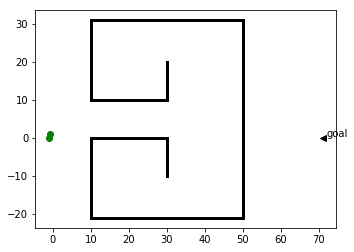

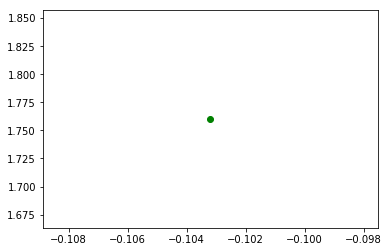

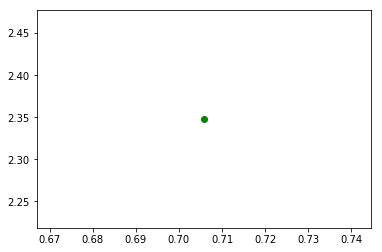

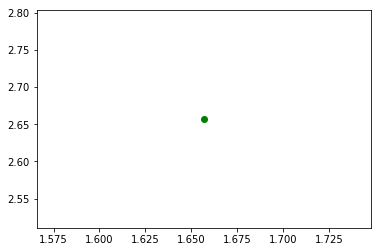

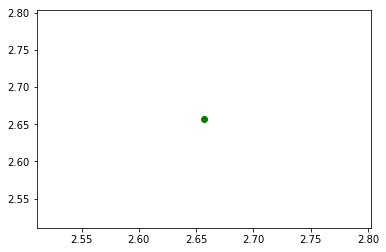

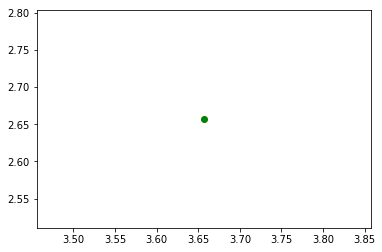

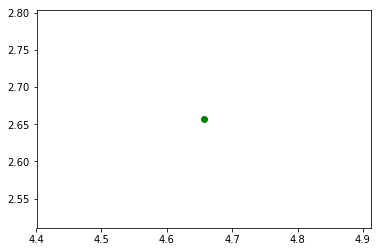

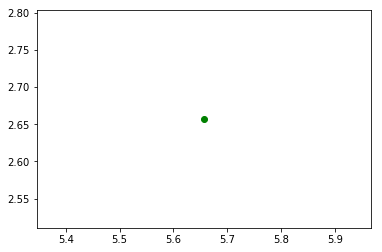

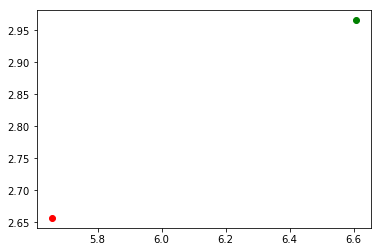

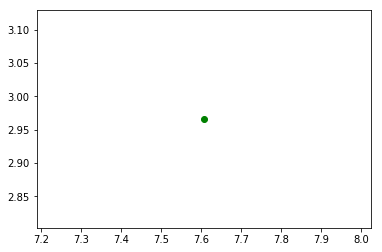

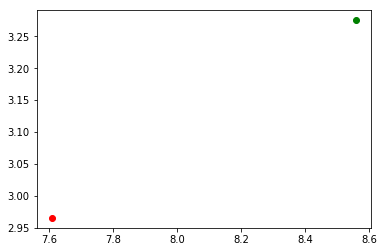

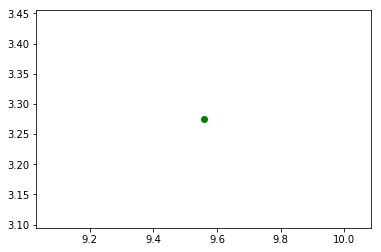

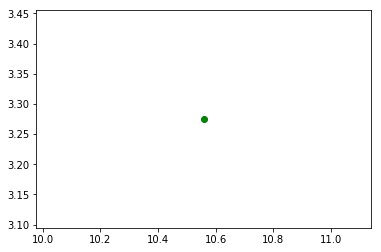

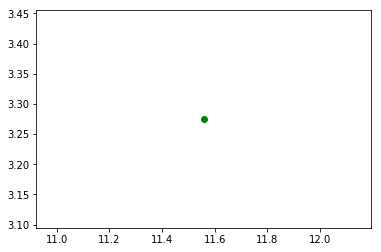

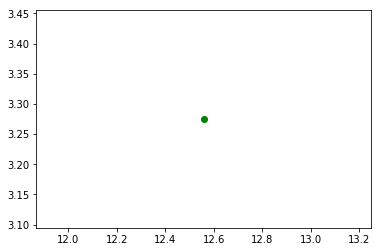

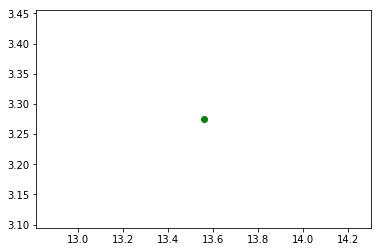

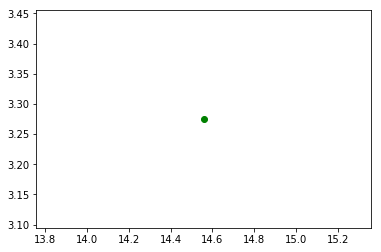

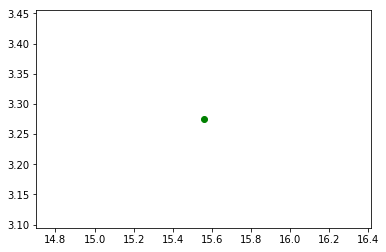

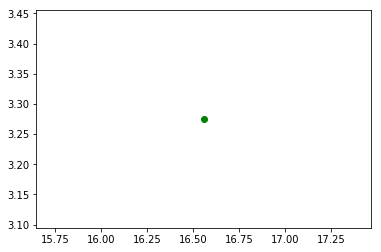

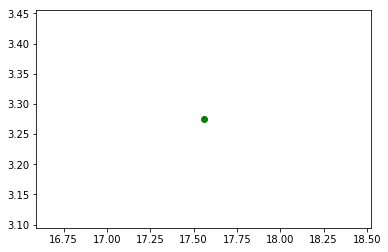

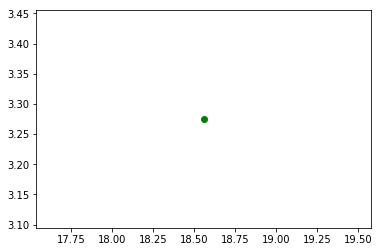

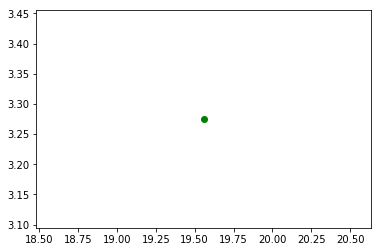

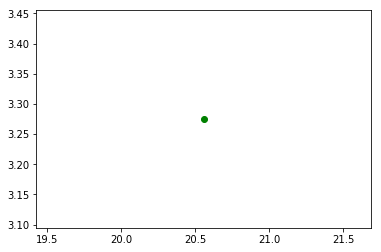

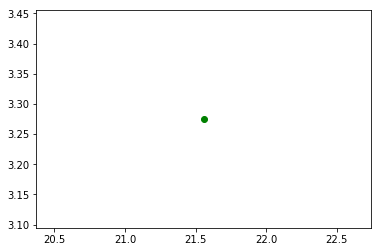

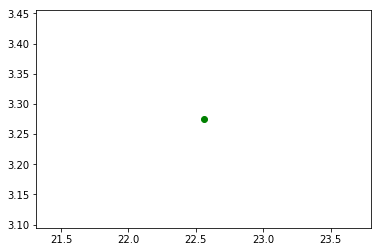

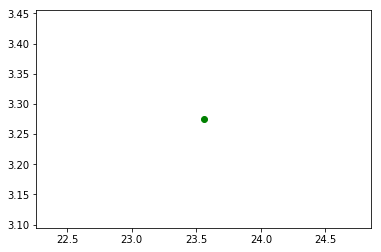

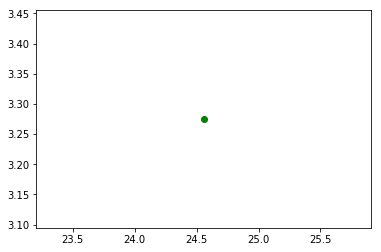

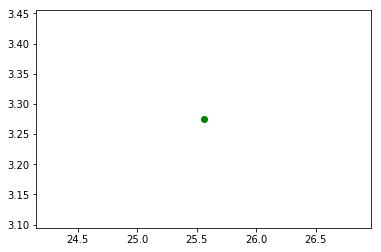

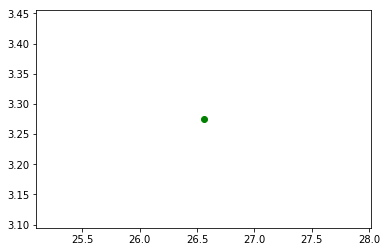

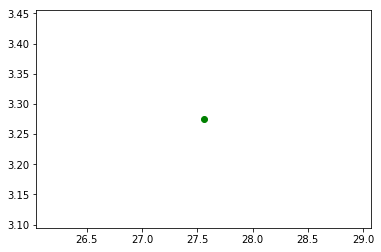

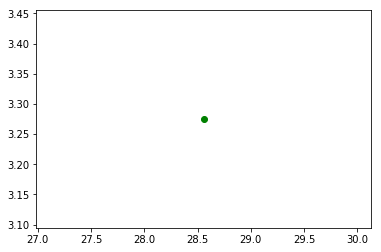

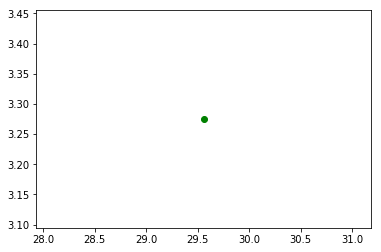

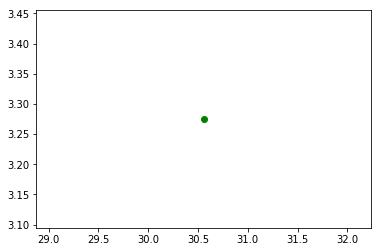

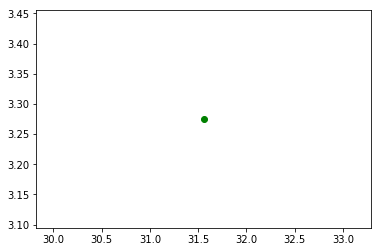

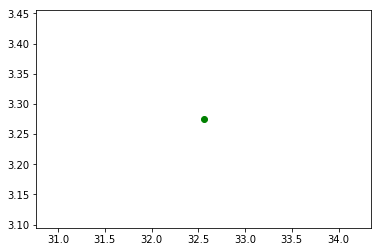

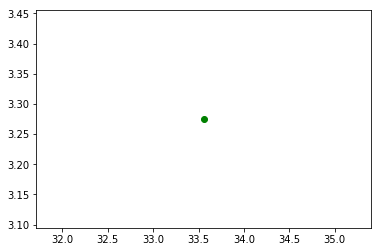

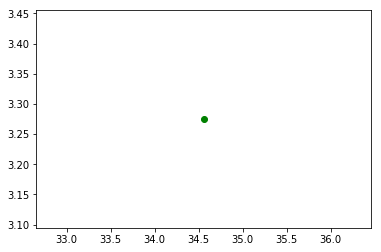

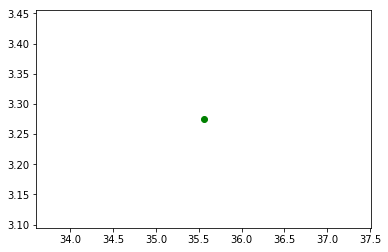

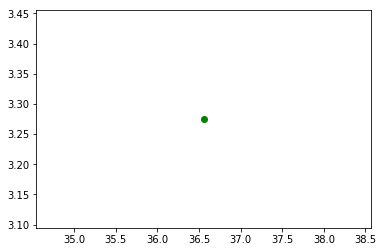

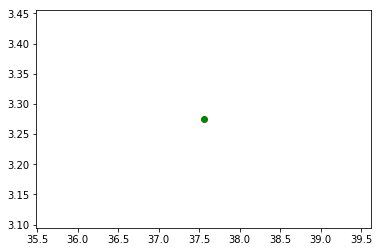

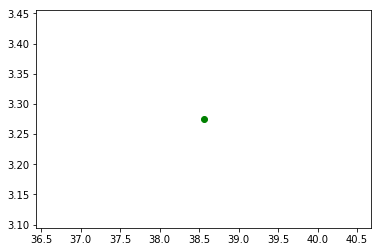

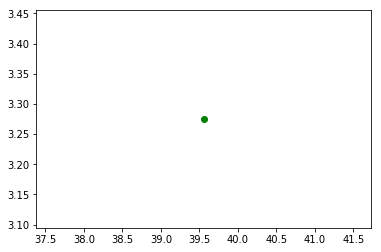

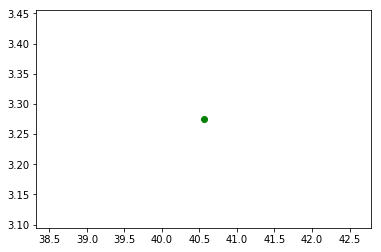

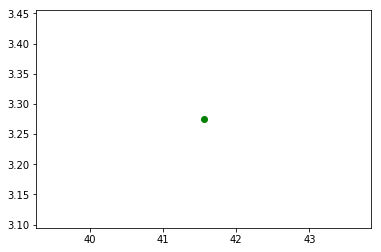

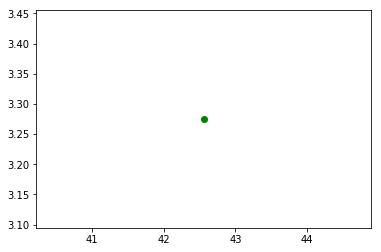

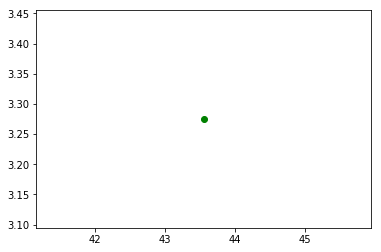

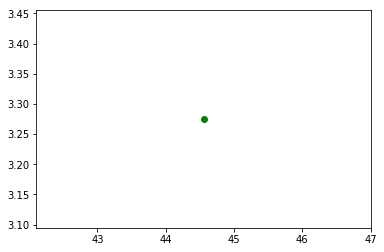

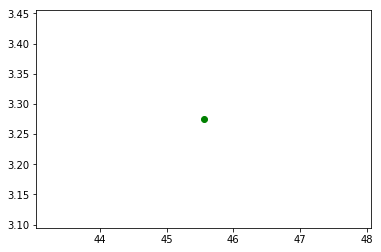

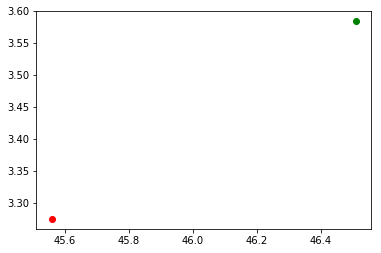

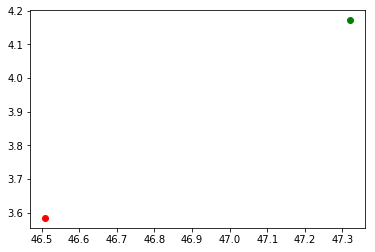

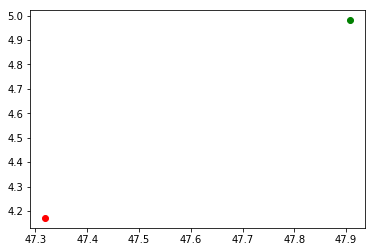

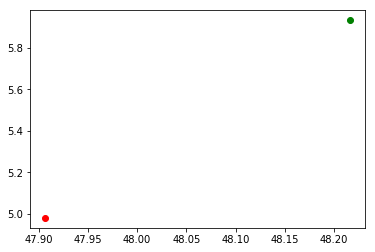

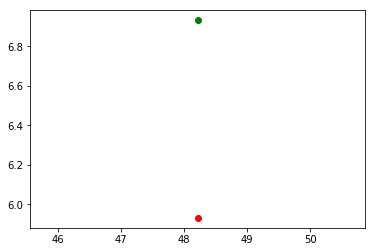

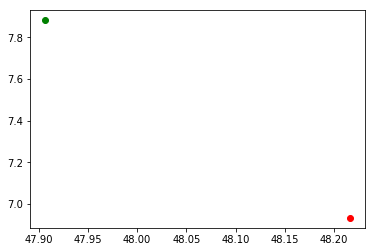

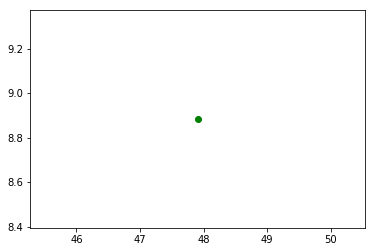

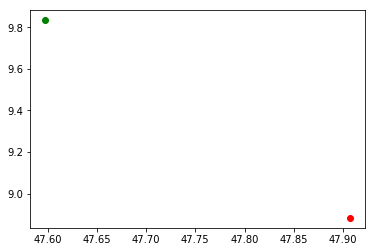

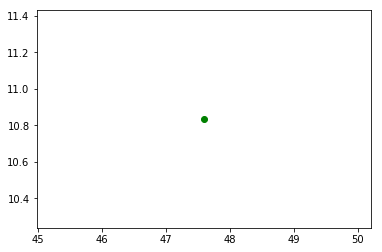

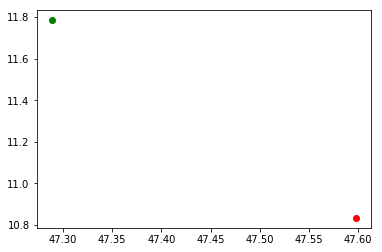

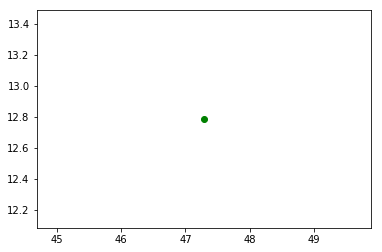

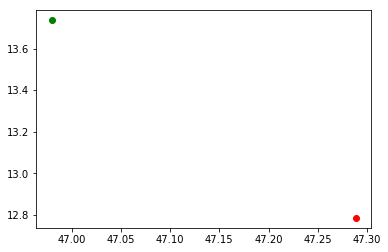

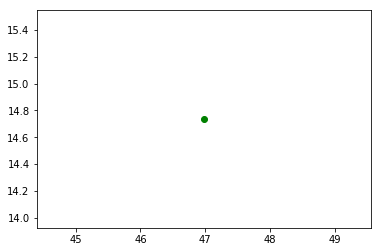

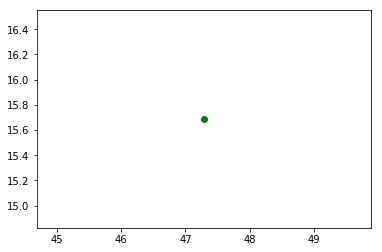

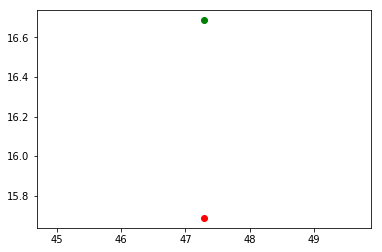

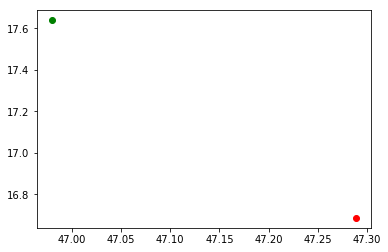

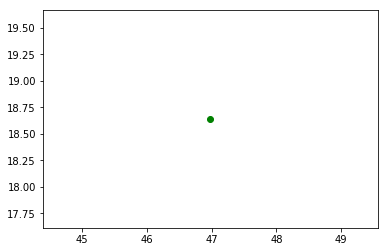

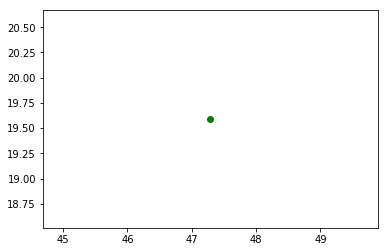

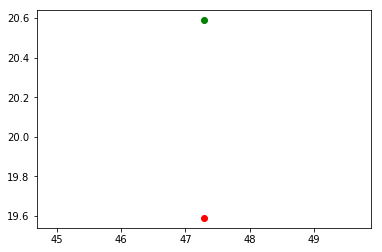

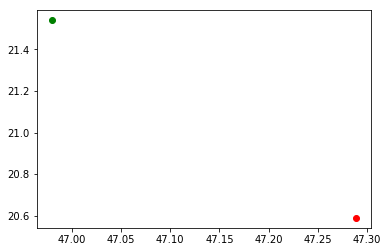

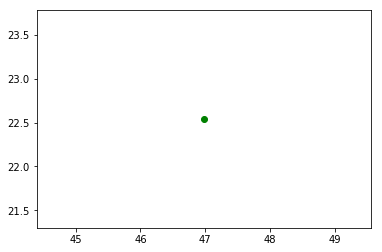

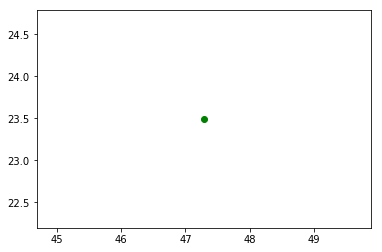

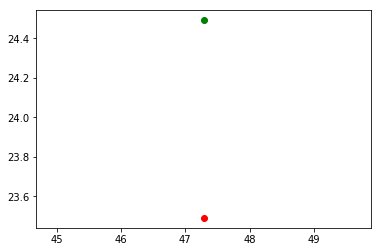

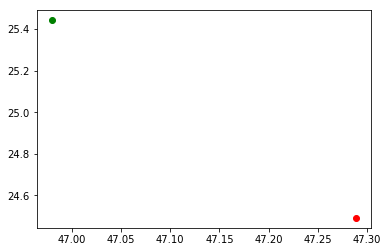

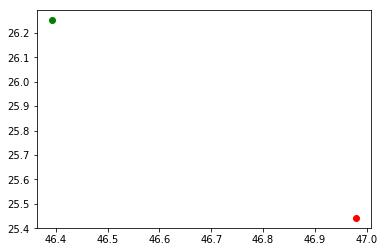

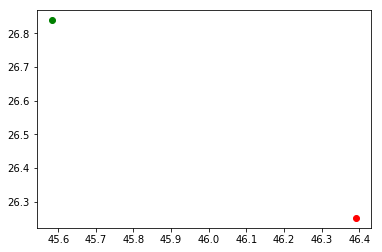

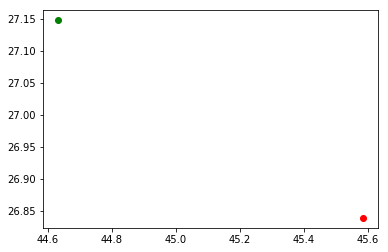

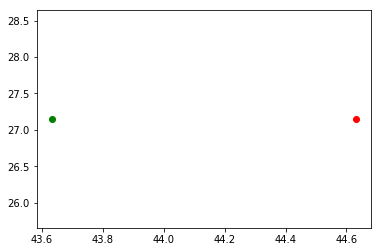

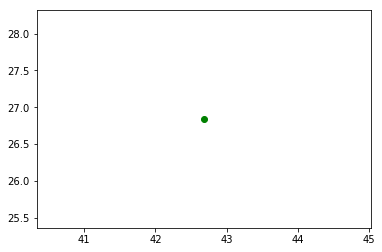

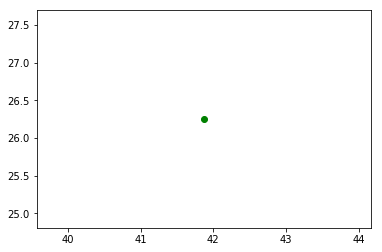

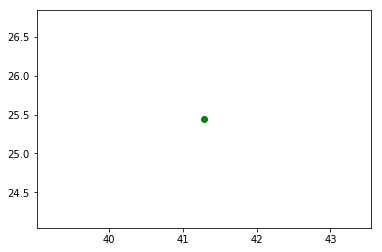

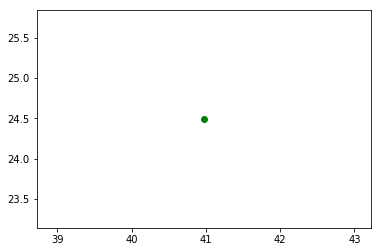

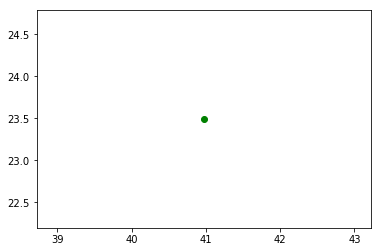

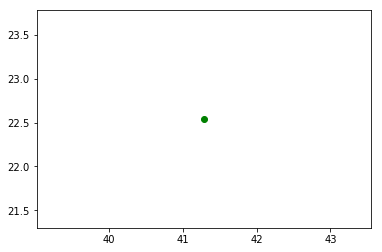

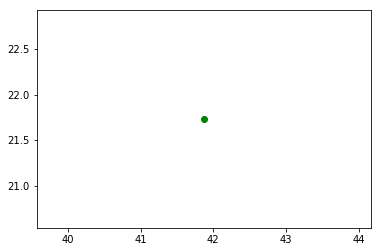

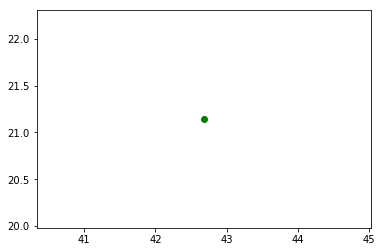

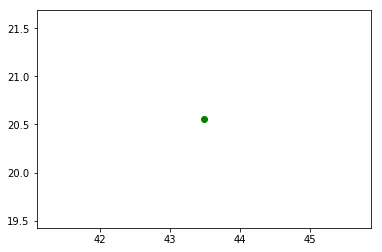

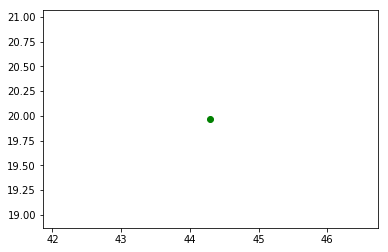

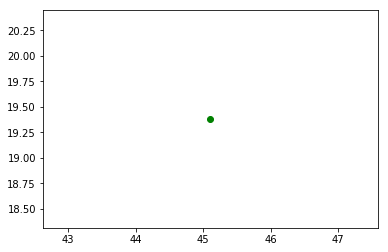

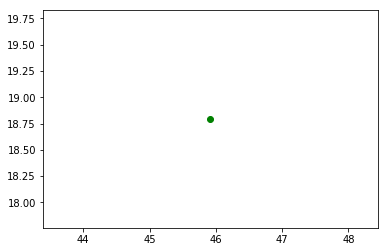

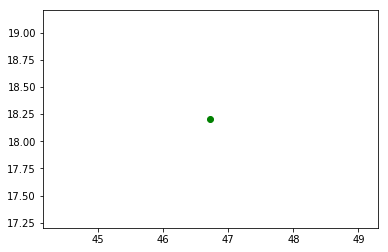

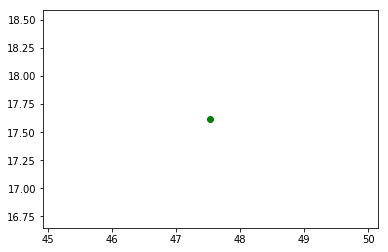

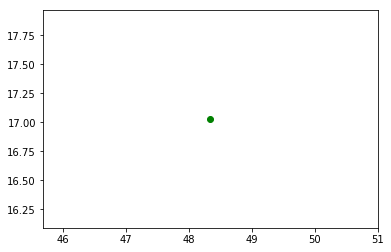

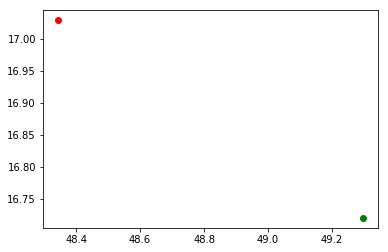

Arrived at goal {'arrived': False}


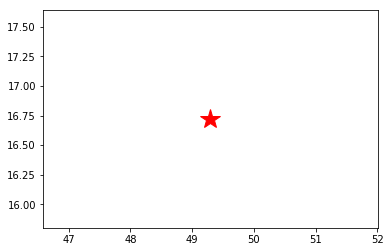

In [61]:
env = Rob_env({
    ((20, 0), (30, 20)),
    ((70, -5), (70, 25))
})
body = Rob_body(env)
middle = Rob_middle_layer(body)
top = Rob_top_layer(middle)

# try:
# pl=Plot_env(body,top)
# top.do({'visit':['o109','storage','o109','o103']})
# You can directly control the middle layer:
# middle.do({'go_to':(30,-10), 'timeout':200})
# Can you make it crash?

# Robot Trap for which the current controller cannot escape:
trap_env = Rob_env({
    ((10, -21), (10, 0)),
    ((10, 10), (10, 31)),
    ((30, -10),(30,0)),
    ((30, 10), (30, 20)),
    ((50, -21), (50, 31)),
    ((10, -21),(50,-21)),
    ((10, 0), (30, 0)),
    ((10, 10), (30, 10)),
    ((10, 31), (50, 31))
})
trap_body = Rob_body(trap_env, init_pos=(-1, 0, 90))
trap_middle = Rob_middle_layer(trap_body)
trap_top = Rob_top_layer(
    trap_middle,
    locations={
        'goal': (71, 0)
    }
)

# Robot trap exercise:
pl = Plot_env(trap_body, trap_top)
trap_top.do({
    'visit': ['goal']
})
